# start

from 0320_3_2; 5e6

In [1]:
PRFX='0320_3_2_2'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])

params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
    'max_delta_step': 1,
}
num_rounds = 800

['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=4: break



2020-03-21 11:36:13 chunk 0
2020-03-21 11:36:29 chunk 1
2020-03-21 11:36:44 chunk 2
2020-03-21 11:36:59 chunk 3
2020-03-21 11:37:14 chunk 4


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(5000000, 95)

In [10]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D65EE42A547283787FF5A

In [11]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [12]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 1.18 s, sys: 1.37 s, total: 2.55 s
Wall time: 2.55 s


In [13]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((4250000, 91), (750000, 91), (4250000, 4), (750000, 4))

# model

In [14]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-21 11:37:26 Retweet ********************************************************************************
[11:38:10] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[11:38:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11039	train-logloss:0.58671	eval-error:0.11117	eval-logloss:0.58796
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[11:38:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.10998	train-logloss:0.50379	eval-error:0.11079	eval-logloss:0.50415
[11:38:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max

[37]	train-error:0.10898	train-logloss:0.31034	eval-error:0.10997	eval-logloss:0.31288
[11:42:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[38]	train-error:0.10898	train-logloss:0.31015	eval-error:0.10996	eval-logloss:0.31271
[11:42:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.10897	train-logloss:0.31009	eval-error:0.10995	eval-logloss:0.31267
[11:42:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.10895	train-logloss:0.30998	eval-error:0.10995	eval-logloss:0.31258
[11:43:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.10891	train-logloss:0.30967	eval-error:0.10989	eval-logloss:0.31230
[11:43:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 e

[77]	train-error:0.10852	train-logloss:0.30727	eval-error:0.10962	eval-logloss:0.31057
[11:47:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[78]	train-error:0.10850	train-logloss:0.30719	eval-error:0.10961	eval-logloss:0.31051
[11:47:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.10849	train-logloss:0.30712	eval-error:0.10960	eval-logloss:0.31045
[11:47:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.10848	train-logloss:0.30704	eval-error:0.10959	eval-logloss:0.31040
[11:47:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.10849	train-logloss:0.30699	eval-error:0.10959	eval-logloss:0.31036
[11:47:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 ex

[11:52:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[117]	train-error:0.10812	train-logloss:0.30538	eval-error:0.10947	eval-logloss:0.30930
[11:52:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[118]	train-error:0.10811	train-logloss:0.30533	eval-error:0.10947	eval-logloss:0.30927
[11:52:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-error:0.10811	train-logloss:0.30528	eval-error:0.10948	eval-logloss:0.30924
[11:52:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.10810	train-logloss:0.30521	eval-error:0.10946	eval-logloss:0.30919
[11:52:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.10810	train-logloss:0.3

[156]	train-error:0.10785	train-logloss:0.30378	eval-error:0.10932	eval-logloss:0.30842
[11:56:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[157]	train-error:0.10785	train-logloss:0.30378	eval-error:0.10932	eval-logloss:0.30842
[11:56:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[158]	train-error:0.10784	train-logloss:0.30374	eval-error:0.10932	eval-logloss:0.30840
[11:57:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[159]	train-error:0.10784	train-logloss:0.30372	eval-error:0.10932	eval-logloss:0.30840
[11:57:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[160]	train-error:0.10784	train-logloss:0.30372	eval-error:0.10933	eval-logloss:0.30840
[11:57:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12

[12:01:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[196]	train-error:0.10758	train-logloss:0.30250	eval-error:0.10920	eval-logloss:0.30785
[12:01:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[197]	train-error:0.10757	train-logloss:0.30247	eval-error:0.10920	eval-logloss:0.30784
[12:01:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[198]	train-error:0.10756	train-logloss:0.30244	eval-error:0.10920	eval-logloss:0.30784
[12:01:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[199]	train-error:0.10756	train-logloss:0.30240	eval-error:0.10920	eval-logloss:0.30783
[12:01:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[200]	train-error:0.10755	train-logloss:0.30

[235]	train-error:0.10737	train-logloss:0.30152	eval-error:0.10915	eval-logloss:0.30757
[12:06:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[236]	train-error:0.10736	train-logloss:0.30149	eval-error:0.10915	eval-logloss:0.30757
[12:06:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[237]	train-error:0.10736	train-logloss:0.30147	eval-error:0.10913	eval-logloss:0.30756
[12:06:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[238]	train-error:0.10736	train-logloss:0.30145	eval-error:0.10913	eval-logloss:0.30755
[12:06:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[239]	train-error:0.10735	train-logloss:0.30145	eval-error:0.10914	eval-logloss:0.30755
[12:06:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 8

[12:10:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[275]	train-error:0.10722	train-logloss:0.30064	eval-error:0.10917	eval-logloss:0.30738
[12:10:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[276]	train-error:0.10721	train-logloss:0.30061	eval-error:0.10916	eval-logloss:0.30736
[12:11:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[277]	train-error:0.10720	train-logloss:0.30058	eval-error:0.10917	eval-logloss:0.30736
[12:11:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[278]	train-error:0.10720	train-logloss:0.30055	eval-error:0.10916	eval-logloss:0.30735
[12:11:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[279]	train-error:0.10720	train-logloss:0.30

[314]	train-error:0.10704	train-logloss:0.29972	eval-error:0.10914	eval-logloss:0.30718
[12:15:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[315]	train-error:0.10703	train-logloss:0.29969	eval-error:0.10914	eval-logloss:0.30717
[12:15:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[316]	train-error:0.10702	train-logloss:0.29967	eval-error:0.10913	eval-logloss:0.30717
[12:16:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[317]	train-error:0.10703	train-logloss:0.29963	eval-error:0.10913	eval-logloss:0.30715
[12:16:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[318]	train-error:0.10702	train-logloss:0.29960	eval-error:0.10913	eval-logloss:0.30714
[12:16:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[12:20:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[354]	train-error:0.10688	train-logloss:0.29888	eval-error:0.10910	eval-logloss:0.30705
[12:20:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[355]	train-error:0.10688	train-logloss:0.29886	eval-error:0.10910	eval-logloss:0.30705
[12:20:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[356]	train-error:0.10687	train-logloss:0.29884	eval-error:0.10910	eval-logloss:0.30705
[12:21:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[357]	train-error:0.10686	train-logloss:0.29881	eval-error:0.10911	eval-logloss:0.30705
[12:21:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[358]	train-error:0.10686	train-logloss:0.2

[393]	train-error:0.10669	train-logloss:0.29801	eval-error:0.10912	eval-logloss:0.30690
[12:25:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[394]	train-error:0.10669	train-logloss:0.29799	eval-error:0.10912	eval-logloss:0.30691
[12:25:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[395]	train-error:0.10669	train-logloss:0.29797	eval-error:0.10911	eval-logloss:0.30691
[12:25:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[396]	train-error:0.10668	train-logloss:0.29795	eval-error:0.10908	eval-logloss:0.30691
[12:25:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[397]	train-error:0.10667	train-logloss:0.29793	eval-error:0.10910	eval-logloss:0.30691
[12:26:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[27]	train-error:0.02747	train-logloss:0.11168	eval-error:0.02758	eval-logloss:0.11263
[12:30:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[28]	train-error:0.02747	train-logloss:0.11160	eval-error:0.02758	eval-logloss:0.11259
[12:30:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[29]	train-error:0.02747	train-logloss:0.11153	eval-error:0.02758	eval-logloss:0.11255
[12:30:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-error:0.02747	train-logloss:0.11147	eval-error:0.02758	eval-logloss:0.11250
[12:31:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-error:0.02747	train-logloss:0.11142	eval-error:0.02758	eval-logloss:0.11247
[12:31:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 e

[67]	train-error:0.02747	train-logloss:0.11019	eval-error:0.02758	eval-logloss:0.11192
[12:35:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[68]	train-error:0.02747	train-logloss:0.11015	eval-error:0.02758	eval-logloss:0.11190
[12:35:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[69]	train-error:0.02747	train-logloss:0.11014	eval-error:0.02758	eval-logloss:0.11190
[12:35:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[70]	train-error:0.02747	train-logloss:0.11011	eval-error:0.02758	eval-logloss:0.11189
[12:36:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[71]	train-error:0.02747	train-logloss:0.11010	eval-error:0.02758	eval-logloss:0.11189
[12:36:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extr

[12:40:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[107]	train-error:0.02746	train-logloss:0.10931	eval-error:0.02759	eval-logloss:0.11173
[12:40:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[108]	train-error:0.02746	train-logloss:0.10930	eval-error:0.02759	eval-logloss:0.11173
[12:40:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[109]	train-error:0.02746	train-logloss:0.10929	eval-error:0.02759	eval-logloss:0.11173
[12:40:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[110]	train-error:0.02746	train-logloss:0.10928	eval-error:0.02759	eval-logloss:0.11173
[12:41:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[111]	train-error:0.02746	train-logloss:0.109

[146]	train-error:0.02745	train-logloss:0.10862	eval-error:0.02758	eval-logloss:0.11163
[12:45:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[147]	train-error:0.02745	train-logloss:0.10860	eval-error:0.02758	eval-logloss:0.11163
[12:45:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[148]	train-error:0.02745	train-logloss:0.10859	eval-error:0.02758	eval-logloss:0.11163
[12:45:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[149]	train-error:0.02745	train-logloss:0.10857	eval-error:0.02758	eval-logloss:0.11163
[12:45:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[150]	train-error:0.02745	train-logloss:0.10855	eval-error:0.02758	eval-logloss:0.11163
[12:45:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[20]	train-error:0.32554	train-logloss:0.60293	eval-error:0.32634	eval-logloss:0.60357
[12:50:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[21]	train-error:0.32527	train-logloss:0.60251	eval-error:0.32601	eval-logloss:0.60317
[12:50:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-error:0.32456	train-logloss:0.60188	eval-error:0.32544	eval-logloss:0.60259
[12:50:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-error:0.32417	train-logloss:0.60155	eval-error:0.32508	eval-logloss:0.60226
[12:51:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[24]	train-error:0.32374	train-logloss:0.60102	eval-error:0.32469	eval-logloss:0.60173
[12:51:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 e

[12:55:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[60]	train-error:0.31686	train-logloss:0.59352	eval-error:0.31841	eval-logloss:0.59491
[12:55:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[61]	train-error:0.31682	train-logloss:0.59346	eval-error:0.31834	eval-logloss:0.59486
[12:55:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[62]	train-error:0.31677	train-logloss:0.59337	eval-error:0.31840	eval-logloss:0.59483
[12:55:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[63]	train-error:0.31674	train-logloss:0.59334	eval-error:0.31840	eval-logloss:0.59482
[12:55:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[64]	train-error:0.31668	train-logloss:0.59330	e

[99]	train-error:0.31357	train-logloss:0.58957	eval-error:0.31550	eval-logloss:0.59169
[13:00:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[100]	train-error:0.31356	train-logloss:0.58954	eval-error:0.31549	eval-logloss:0.59169
[13:00:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[101]	train-error:0.31355	train-logloss:0.58945	eval-error:0.31549	eval-logloss:0.59161
[13:00:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[102]	train-error:0.31351	train-logloss:0.58942	eval-error:0.31546	eval-logloss:0.59160
[13:00:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[103]	train-error:0.31340	train-logloss:0.58934	eval-error:0.31530	eval-logloss:0.59153
[13:00:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10

[13:05:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[139]	train-error:0.31145	train-logloss:0.58687	eval-error:0.31400	eval-logloss:0.58964
[13:05:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[140]	train-error:0.31143	train-logloss:0.58685	eval-error:0.31398	eval-logloss:0.58962
[13:05:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[141]	train-error:0.31137	train-logloss:0.58679	eval-error:0.31400	eval-logloss:0.58958
[13:05:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[142]	train-error:0.31132	train-logloss:0.58671	eval-error:0.31388	eval-logloss:0.58951
[13:05:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[143]	train-error:0.31128	train-logloss:0.586

[178]	train-error:0.30979	train-logloss:0.58482	eval-error:0.31251	eval-logloss:0.58828
[13:10:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[179]	train-error:0.30976	train-logloss:0.58480	eval-error:0.31255	eval-logloss:0.58826
[13:10:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[180]	train-error:0.30973	train-logloss:0.58474	eval-error:0.31255	eval-logloss:0.58822
[13:10:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[181]	train-error:0.30967	train-logloss:0.58466	eval-error:0.31252	eval-logloss:0.58818
[13:10:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[182]	train-error:0.30964	train-logloss:0.58464	eval-error:0.31250	eval-logloss:0.58817
[13:10:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12

[13:15:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[218]	train-error:0.30817	train-logloss:0.58285	eval-error:0.31162	eval-logloss:0.58701
[13:15:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[219]	train-error:0.30811	train-logloss:0.58281	eval-error:0.31159	eval-logloss:0.58700
[13:15:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[220]	train-error:0.30809	train-logloss:0.58278	eval-error:0.31156	eval-logloss:0.58699
[13:15:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[221]	train-error:0.30796	train-logloss:0.58265	eval-error:0.31147	eval-logloss:0.58687
[13:15:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[222]	train-error:0.30791	train-logloss:0.58

[257]	train-error:0.30680	train-logloss:0.58112	eval-error:0.31070	eval-logloss:0.58602
[13:19:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[258]	train-error:0.30678	train-logloss:0.58111	eval-error:0.31068	eval-logloss:0.58601
[13:20:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[259]	train-error:0.30678	train-logloss:0.58110	eval-error:0.31068	eval-logloss:0.58601
[13:20:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[260]	train-error:0.30673	train-logloss:0.58105	eval-error:0.31064	eval-logloss:0.58598
[13:20:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[261]	train-error:0.30665	train-logloss:0.58099	eval-error:0.31062	eval-logloss:0.58592
[13:20:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12

[13:24:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[297]	train-error:0.30530	train-logloss:0.57939	eval-error:0.30976	eval-logloss:0.58492
[13:24:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[298]	train-error:0.30526	train-logloss:0.57935	eval-error:0.30978	eval-logloss:0.58490
[13:24:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[299]	train-error:0.30523	train-logloss:0.57931	eval-error:0.30971	eval-logloss:0.58486
[13:24:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[300]	train-error:0.30520	train-logloss:0.57927	eval-error:0.30974	eval-logloss:0.58485
[13:25:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[301]	train-error:0.30516	train-logloss:0.5

[336]	train-error:0.30427	train-logloss:0.57801	eval-error:0.30925	eval-logloss:0.58419
[13:29:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[337]	train-error:0.30427	train-logloss:0.57800	eval-error:0.30923	eval-logloss:0.58418
[13:29:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[338]	train-error:0.30425	train-logloss:0.57797	eval-error:0.30924	eval-logloss:0.58416
[13:29:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[339]	train-error:0.30420	train-logloss:0.57793	eval-error:0.30923	eval-logloss:0.58415
[13:30:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[340]	train-error:0.30417	train-logloss:0.57790	eval-error:0.30924	eval-logloss:0.58414
[13:30:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6

[13:34:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[376]	train-error:0.30338	train-logloss:0.57687	eval-error:0.30895	eval-logloss:0.58376
[13:34:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[377]	train-error:0.30335	train-logloss:0.57685	eval-error:0.30894	eval-logloss:0.58374
[13:34:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[378]	train-error:0.30334	train-logloss:0.57682	eval-error:0.30893	eval-logloss:0.58374
[13:34:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[379]	train-error:0.30329	train-logloss:0.57677	eval-error:0.30892	eval-logloss:0.58371
[13:34:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[380]	train-error:0.30322	train-logloss:0.5

[415]	train-error:0.30227	train-logloss:0.57556	eval-error:0.30814	eval-logloss:0.58306
[13:39:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[416]	train-error:0.30222	train-logloss:0.57549	eval-error:0.30808	eval-logloss:0.58300
[13:39:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[417]	train-error:0.30218	train-logloss:0.57544	eval-error:0.30809	eval-logloss:0.58297
[13:39:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[418]	train-error:0.30214	train-logloss:0.57540	eval-error:0.30804	eval-logloss:0.58294
[13:39:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[419]	train-error:0.30212	train-logloss:0.57535	eval-error:0.30804	eval-logloss:0.58292
[13:39:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[13:43:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[455]	train-error:0.30125	train-logloss:0.57428	eval-error:0.30777	eval-logloss:0.58246
[13:44:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[456]	train-error:0.30123	train-logloss:0.57426	eval-error:0.30774	eval-logloss:0.58246
[13:44:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[457]	train-error:0.30121	train-logloss:0.57424	eval-error:0.30775	eval-logloss:0.58244
[13:44:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[458]	train-error:0.30121	train-logloss:0.57423	eval-error:0.30775	eval-logloss:0.58244
[13:44:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[459]	train-error:0.30120	train-logloss:0.574

[494]	train-error:0.30050	train-logloss:0.57330	eval-error:0.30730	eval-logloss:0.58210
[13:48:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[495]	train-error:0.30050	train-logloss:0.57328	eval-error:0.30731	eval-logloss:0.58210
[13:49:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[496]	train-error:0.30047	train-logloss:0.57325	eval-error:0.30730	eval-logloss:0.58209
[13:49:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[497]	train-error:0.30046	train-logloss:0.57323	eval-error:0.30733	eval-logloss:0.58209
[13:49:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[498]	train-error:0.30040	train-logloss:0.57319	eval-error:0.30734	eval-logloss:0.58207
[13:49:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[13:54:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[534]	train-error:0.29964	train-logloss:0.57222	eval-error:0.30694	eval-logloss:0.58174
[13:54:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[535]	train-error:0.29962	train-logloss:0.57221	eval-error:0.30695	eval-logloss:0.58173
[13:54:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[536]	train-error:0.29959	train-logloss:0.57218	eval-error:0.30694	eval-logloss:0.58172
[13:54:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[537]	train-error:0.29958	train-logloss:0.57216	eval-error:0.30695	eval-logloss:0.58172
[13:54:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[538]	train-error:0.29954	train-logloss:0.57

[573]	train-error:0.29900	train-logloss:0.57138	eval-error:0.30678	eval-logloss:0.58151
[13:59:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[574]	train-error:0.29897	train-logloss:0.57136	eval-error:0.30683	eval-logloss:0.58150
[13:59:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[575]	train-error:0.29896	train-logloss:0.57133	eval-error:0.30682	eval-logloss:0.58149
[13:59:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[576]	train-error:0.29895	train-logloss:0.57132	eval-error:0.30680	eval-logloss:0.58149
[14:00:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[577]	train-error:0.29893	train-logloss:0.57130	eval-error:0.30673	eval-logloss:0.58149
[14:00:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[14:04:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[613]	train-error:0.29827	train-logloss:0.57045	eval-error:0.30666	eval-logloss:0.58124
[14:05:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[614]	train-error:0.29827	train-logloss:0.57044	eval-error:0.30669	eval-logloss:0.58124
[14:05:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[615]	train-error:0.29827	train-logloss:0.57041	eval-error:0.30672	eval-logloss:0.58123
[14:05:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[616]	train-error:0.29824	train-logloss:0.57038	eval-error:0.30669	eval-logloss:0.58122
[14:05:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[617]	train-error:0.29823	train-logloss:0.5

[652]	train-error:0.29762	train-logloss:0.56955	eval-error:0.30652	eval-logloss:0.58091
[14:09:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[653]	train-error:0.29763	train-logloss:0.56952	eval-error:0.30653	eval-logloss:0.58091
[14:09:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[654]	train-error:0.29761	train-logloss:0.56950	eval-error:0.30654	eval-logloss:0.58090
[14:10:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[655]	train-error:0.29757	train-logloss:0.56948	eval-error:0.30654	eval-logloss:0.58090
[14:10:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[656]	train-error:0.29755	train-logloss:0.56944	eval-error:0.30648	eval-logloss:0.58086
[14:10:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[14:14:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[692]	train-error:0.29700	train-logloss:0.56878	eval-error:0.30642	eval-logloss:0.58074
[14:14:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[693]	train-error:0.29699	train-logloss:0.56876	eval-error:0.30641	eval-logloss:0.58074
[14:14:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[694]	train-error:0.29697	train-logloss:0.56870	eval-error:0.30639	eval-logloss:0.58070
[14:14:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[695]	train-error:0.29694	train-logloss:0.56868	eval-error:0.30638	eval-logloss:0.58070
[14:15:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[696]	train-error:0.29694	train-logloss:0.5

[731]	train-error:0.29627	train-logloss:0.56792	eval-error:0.30603	eval-logloss:0.58044
[14:19:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[732]	train-error:0.29628	train-logloss:0.56791	eval-error:0.30602	eval-logloss:0.58045
[14:19:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[733]	train-error:0.29627	train-logloss:0.56789	eval-error:0.30603	eval-logloss:0.58045
[14:19:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[734]	train-error:0.29624	train-logloss:0.56787	eval-error:0.30604	eval-logloss:0.58045
[14:19:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[735]	train-error:0.29623	train-logloss:0.56785	eval-error:0.30602	eval-logloss:0.58045
[14:19:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12

[11]	train-error:0.00771	train-logloss:0.05655	eval-error:0.00792	eval-logloss:0.05736
[14:23:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[12]	train-error:0.00771	train-logloss:0.05207	eval-error:0.00792	eval-logloss:0.05289
[14:23:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-error:0.00771	train-logloss:0.04900	eval-error:0.00792	eval-logloss:0.04989
[14:23:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-error:0.00771	train-logloss:0.04694	eval-error:0.00792	eval-logloss:0.04790
[14:24:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[15]	train-error:0.00771	train-logloss:0.04561	eval-error:0.00792	eval-logloss:0.04659
[14:24:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 e

[51]	train-error:0.00771	train-logloss:0.04223	eval-error:0.00792	eval-logloss:0.04393
[14:29:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[52]	train-error:0.00771	train-logloss:0.04221	eval-error:0.00792	eval-logloss:0.04392
[14:29:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[53]	train-error:0.00771	train-logloss:0.04218	eval-error:0.00792	eval-logloss:0.04392
[14:30:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[54]	train-error:0.00771	train-logloss:0.04217	eval-error:0.00792	eval-logloss:0.04392
[14:30:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[55]	train-error:0.00771	train-logloss:0.04216	eval-error:0.00792	eval-logloss:0.04392
[14:30:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra

[91]	train-error:0.00771	train-logloss:0.04164	eval-error:0.00792	eval-logloss:0.04387
[14:37:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[92]	train-error:0.00771	train-logloss:0.04162	eval-error:0.00792	eval-logloss:0.04387
[14:37:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[93]	train-error:0.00771	train-logloss:0.04160	eval-error:0.00792	eval-logloss:0.04387
[14:37:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[94]	train-error:0.00771	train-logloss:0.04159	eval-error:0.00792	eval-logloss:0.04387
Stopping. Best iteration:
[84]	train-error:0.00771	train-logloss:0.04175	eval-error:0.00792	eval-logloss:0.04387



In [15]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


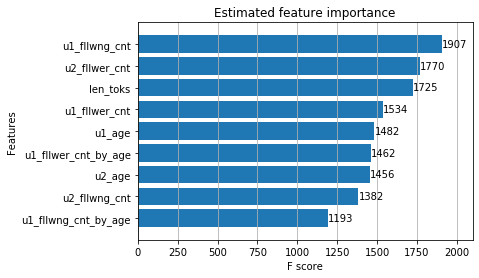

,0,1
8,u1_fllwng_cnt,1907
9,u2_fllwer_cnt,1770
3,len_toks,1725
2,u1_fllwer_cnt,1534
10,u1_age,1482
12,u1_fllwer_cnt_by_age,1462
15,u2_age,1456
1,u2_fllwng_cnt,1382
17,u1_fllwng_cnt_by_age,1193
33,twt_age,1108


Reply


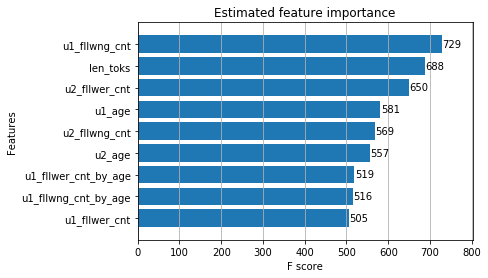

,0,1
18,u1_fllwng_cnt,729
12,len_toks,688
25,u2_fllwer_cnt,650
15,u1_age,581
5,u2_fllwng_cnt,569
1,u2_age,557
11,u1_fllwer_cnt_by_age,519
4,u1_fllwng_cnt_by_age,516
19,u1_fllwer_cnt,505
14,twt_age,478


Like


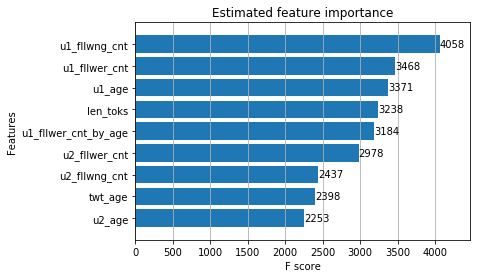

,0,1
26,u1_fllwng_cnt,4058
12,u1_fllwer_cnt,3468
6,u1_age,3371
3,len_toks,3238
4,u1_fllwer_cnt_by_age,3184
9,u2_fllwer_cnt,2978
11,u2_fllwng_cnt,2437
20,twt_age,2398
13,u2_age,2253
2,u1_fllwng_cnt_by_age,2098


RTwCmnt


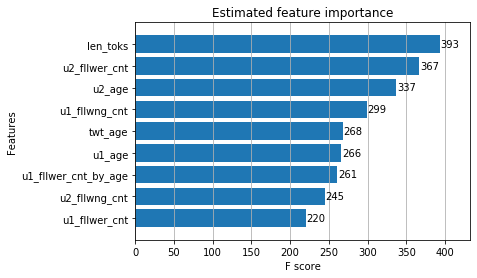

,0,1
6,len_toks,393
0,u2_fllwer_cnt,367
2,u2_age,337
23,u1_fllwng_cnt,299
21,twt_age,268
17,u1_age,266
8,u1_fllwer_cnt_by_age,261
7,u2_fllwng_cnt,245
12,u1_fllwer_cnt,220
11,tmdlta_u2u1,217


In [16]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

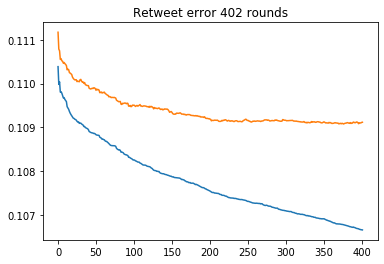

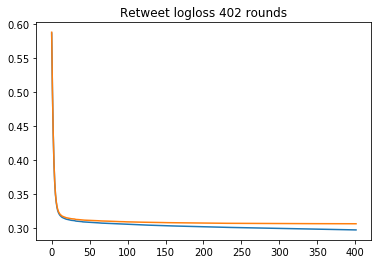

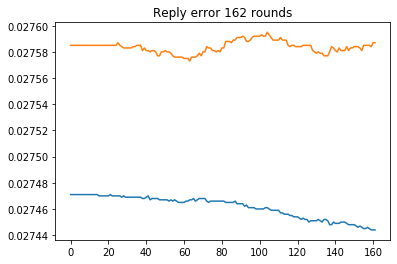

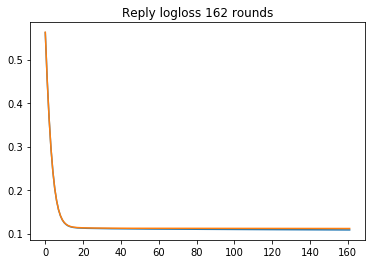

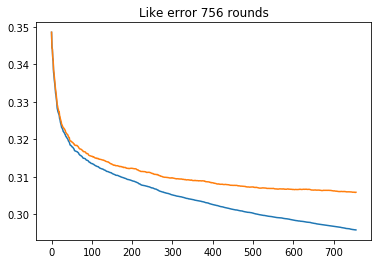

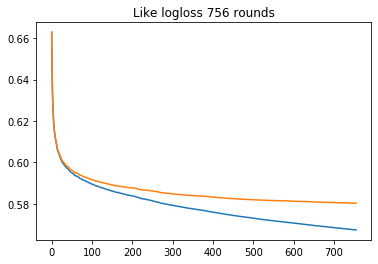

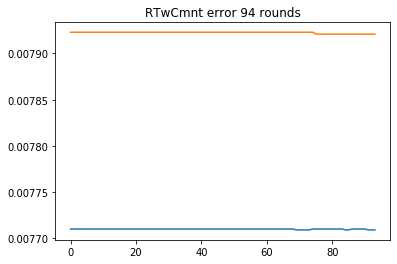

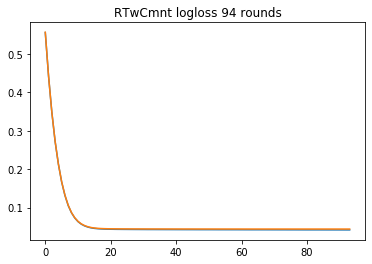

In [17]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [18]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-21 14:37:20 Retweet
2020-03-21 14:37:35 Reply
2020-03-21 14:37:40 Like
2020-03-21 14:38:13 RTwCmnt


In [19]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7713 valid auc: 0.7524
train prauc: 0.3624 valid auc: 0.3312
train rce: 15.5295 valid rce: 13.2934
Reply
train rocauc: 0.8000 valid auc: 0.7791
train prauc: 0.1283 valid auc: 0.1024
train rce: 13.8933 valid rce: 11.5832
Like
train rocauc: 0.7692 valid auc: 0.7549
train prauc: 0.7203 valid auc: 0.6999
train rce: 17.2642 valid rce: 15.3576
RTwCmnt
train rocauc: 0.7547 valid auc: 0.7096
train prauc: 0.0362 valid auc: 0.0228
train rce: 7.9553 valid rce: 5.0874


In [20]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.36243,15.5295,0.128303,13.8933,0.720346,17.2642,0.0362068,7.95526
scrval,0.331239,13.2934,0.102388,11.5832,0.69985,15.3576,0.0227684,5.08737


# infer

In [21]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 41s, sys: 8.96 s, total: 1min 50s
Wall time: 1min 50s


In [22]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 54s, sys: 10.6 s, total: 2min 5s
Wall time: 2min 5s


In [23]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-21 14:44:50 Retweet
2020-03-21 14:45:34 Reply
2020-03-21 14:45:51 Like
2020-03-21 14:47:53 RTwCmnt
CPU times: user 38min 11s, sys: 36.8 s, total: 38min 48s
Wall time: 5min 16s


In [24]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [25]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-21 14:48:03 Retweet
2020-03-21 14:49:00 Reply
2020-03-21 14:49:58 Like
2020-03-21 14:50:53 RTwCmnt
CPU times: user 3min 40s, sys: 6.82 s, total: 3min 47s
Wall time: 3min 48s
